<a href="https://colab.research.google.com/github/IhorTkachMykol/project/blob/main/captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Завантаження датасету CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Нормалізація зображень
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_test = (x_test.astype(np.float32) - 127.5) / 127.5

# Розміри зображень
img_shape = x_train.shape[1:]

# Розмір латентного простору
latent_dim = 100

# Створення генератора
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
    model.add(layers.Reshape(img_shape))

    noise = tf.keras.Input(shape=(latent_dim,))
    img = model(noise)

    return tf.keras.Model(noise, img)

# Створення дискримінатора
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    img = tf.keras.Input(shape=img_shape)
    validity = model(img)

    return tf.keras.Model(img, validity)

# Компіляція моделей
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Замороження дискримінатора під час навчання генератора
discriminator.trainable = False

# Побудова GAN моделі
z = tf.keras.Input(shape=(latent_dim,))
img = generator(z)
valid = discriminator(img)

combined = tf.keras.Model(z, valid)
combined.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')

# Функція для навчання моделей
def train(epochs, batch_size=128, save_interval=50):
    # Завантаження та нормалізація даних
    (x_train, _), (_, _) = cifar10.load_data()
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis=3)

    # Етапи навчання
    for epoch in range(epochs):
        # Відбір випадкових зображень
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]

        # Генерація випадкового шуму та створення зображень
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Навчання дискримінатора
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Навчання генератора
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # Збереження прогресу
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}] [D accuracy: {d_loss[1]*100}%] [G loss: {g_loss}]")

# Навчання моделей
train(epochs=10000, batch_size=64)


2/2 [==============================] - 1s 7ms/step


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(64, 32, 32, 1, 3)


Показано результат, скорочений до останніх рядків (5000).
2/2 [==============================] - 0s 5ms/step
6000 [D loss: 0.3115348070859909] [D accuracy: 85.9375%] [G loss: 2.944575071334839]
2/2 [==============================] - 0s 6ms/step
7000 [D loss: 0.25236470252275467] [D accuracy: 91.40625%] [G loss: 3.3921494483947754]
2/2 [==============================] - 0s 6ms/step
8000 [D loss: 0.3358483165502548] [D accuracy: 86.71875%] [G loss: 2.641084671020508]
2/2 [==============================] - 0s 5ms/step
9000 [D loss: 0.3372025489807129] [D accuracy: 86.71875%] [G loss: 2.744431495666504]
1/1 [==============================] - 0s 127ms/step


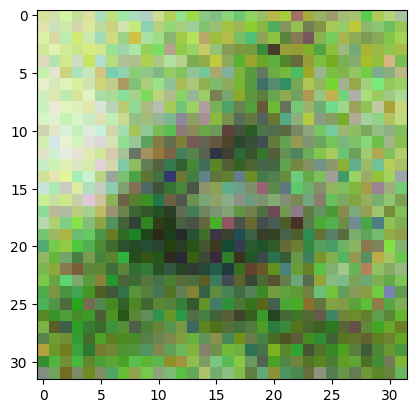

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Завантаження датасету CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Нормалізація зображень
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_test = (x_test.astype(np.float32) - 127.5) / 127.5

# Розміри зображень
img_shape = x_train.shape[1:]

# Розмір латентного простору
latent_dim = 100

# Створення генератора
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
    model.add(layers.Reshape(img_shape))

    noise = tf.keras.Input(shape=(latent_dim,))
    img = model(noise)

    return tf.keras.Model(noise, img)

# Створення дискримінатора
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    img = tf.keras.Input(shape=img_shape)
    validity = model(img)

    return tf.keras.Model(img, validity)

# Компіляція моделей
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Замороження дискримінатора під час навчання генератора
discriminator.trainable = False

# Побудова GAN моделі
z = tf.keras.Input(shape=(latent_dim,))
img = generator(z)
valid = discriminator(img)

combined = tf.keras.Model(z, valid)
combined.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')

# Функція для навчання моделей
def train(epochs, batch_size=128, save_interval=50):
    # Завантаження та нормалізація даних
    (x_train, _), (_, _) = cifar10.load_data()
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5

    # Етапи навчання
    for epoch in range(epochs):
        # Відбір випадкових зображень
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]

        # Генерація випадкового шуму та створення зображень
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Навчання дискримінатора
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Навчання генератора
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # Збереження прогресу
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}] [D accuracy: {d_loss[1]*100}%] [G loss: {g_loss}]")


# Навчання моделей
train(epochs=10000, batch_size=64, save_interval=1000)

# Функція для створення CAPTCHA
def generate_captcha():
    noise = np.random.normal(0, 1, (1, latent_dim))
    gen_img = generator.predict(noise)
    return gen_img

# Створення CAPTCHA
captcha_img = generate_captcha()
plt.imshow((captcha_img.reshape(32, 32, 3) * 127.5 + 127.5).astype(np.uint8))
plt.show()


In [8]:
generator.save('my_model.keras')
discriminator.save('m_model.keras')

In [6]:
model.save('my_model.keras')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


NameError: name 'model' is not defined